In [27]:
import wandb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull
from matplotlib.colors import Normalize  
from matplotlib.colors import LogNorm  
from matplotlib.ticker import FormatStrFormatter, LogFormatter  
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
api = wandb.Api(timeout=300)

In [48]:
run_path_list = [
    '/ai4s-sfm/nlm_base1b_300B/7281332536.14328-4ef0730b-d1d2-402a-9ea4-416c338d4cec', #1B
    '/ai4s-sfm/nlm_llama3/7282428284.52203-8e58f189-34ba-453b-a943-89ee6d43679d', #8B,
    '/ai4s-sfm/NLM_MOE/7284256402.08954-3e28be03-00ec-4c6d-b9c9-87e3d644e613', #8x7B
]

lengend_names = [
    'NLM-1B',
    'NLM-8B',
    'NLM-8x7B'
]

tokens_per_iter_list = [
    4096 * 8192,
    2048 * 8192,
    1536 * 8192
]

num_params_list = [
    1259427843,
    8000000000,
    46000000000
]


compute_values = []
loss_values = []
param_values = []


D = 6000000

for run_idx, run_path in enumerate(run_path_list):
    run = api.run(run_path)
    
    global_step = []
    losses = []
    compute = []
    intervel = 5
    N = num_params_list[run_idx]
    for idx, step in enumerate(run.scan_history()):
        if 'train_inner/global_step' in step and 'train_inner/loss' in step and idx % intervel == 0:
            s = step['train_inner/global_step']
            if s is not None:
                global_step.append(step['train_inner/global_step'])
                losses.append(step['train_inner/loss'])
                compute.append(6 * N * global_step[-1] * tokens_per_iter_list[run_idx])
    
    compute_values.append(compute)
    loss_values.append(losses)
    param_values.append([N] * len(compute))

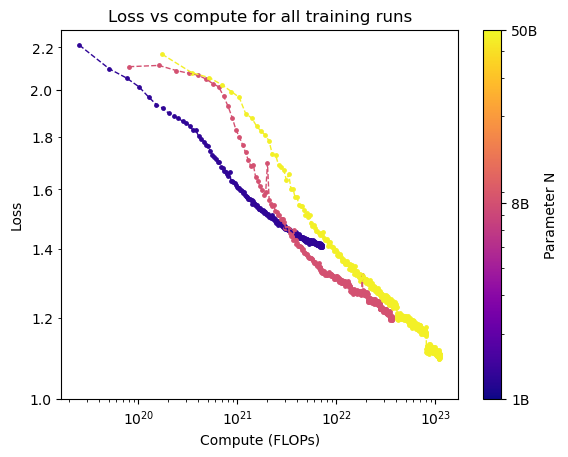

In [49]:
min_val = 1000000000
max_val = 50000000000
norm = LogNorm(vmin=min_val, vmax=max_val)
cmap = plt.get_cmap('plasma')  


for idx in range(len(compute_values)):
    color = cmap(norm(param_values[idx][0]))
    plt.scatter(compute_values[idx], loss_values[idx], color=color, s=6)
    plt.plot(compute_values[idx], loss_values[idx], '--', linewidth=1, color=color)

sc = plt.scatter([], [], c=[], cmap='plasma', norm=norm)  

# Add a color bar with a label  
cbar = plt.colorbar(sc, norm=norm)  
cbar.set_label('Parameter N')  
cbar_ticks = [min_val, min_val*8, max_val]  
cbar.set_ticks(cbar_ticks)  
cbar.set_ticklabels(['1B', '8B', '50B'])  

plt.xscale("log")  
plt.yscale("log")  
plt.xlabel("Compute (FLOPs)")  
plt.ylabel("Loss")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
plt.yticks(np.arange(1.0, 2.5))


plt.title("Loss vs compute for all training runs")  

plt.show()

In [45]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 4)
fig.savefig('./nlm_scalinglaw.png', dpi=300)


<Figure size 800x400 with 0 Axes>